# Homework and bake-off: Word similarity

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

`VSM` = Vector Space-Model

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Dataset readers](#Dataset-readers)
1. [Dataset comparisons](#Dataset-comparisons)
  1. [Vocab overlap](#Vocab-overlap)
  1. [Pair overlap and score correlations](#Pair-overlap-and-score-correlations)
1. [Evaluation](#Evaluation)
  1. [Dataset evaluation](#Dataset-evaluation)
  1. [Dataset error analysis](#Dataset-error-analysis)
  1. [Full evaluation](#Full-evaluation)
1. [Homework questions](#Homework-questions)
  1. [PPMI as a baseline [0.5 points]](#PPMI-as-a-baseline-[0.5-points])
  1. [Gigaword with LSA at different dimensions [0.5 points]](#Gigaword-with-LSA-at-different-dimensions-[0.5-points])
  1. [Gigaword with GloVe [0.5 points]](#Gigaword-with-GloVe-[0.5-points])
  1. [Dice coefficient [0.5 points]](#Dice-coefficient-[0.5-points])
  1. [t-test reweighting [2 points]](#t-test-reweighting-[2-points])
  1. [Enriching a VSM with subword information [2 points]](#Enriching-a-VSM-with-subword-information-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])

## Overview

Word similarity datasets have long been used to evaluate distributed representations. This notebook provides basic code for conducting such analyses with a number of datasets:

| Dataset | Pairs | Task-type | Current best Spearman $\rho$ | Best $\rho$ paper |   |
|---------|-------|-----------|------------------------------|-------------------|---|
| [WordSim-353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/) | 353 | Relatedness | 82.8 | [Speer et al. 2017](https://arxiv.org/abs/1612.03975) |
| [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) | 771 | Relatedness | 81.0 | [Speer et al. 2017](https://arxiv.org/abs/1612.03975) |
| [The MEN Test Collection](http://clic.cimec.unitn.it/~elia.bruni/MEN) | 3,000 | Relatedness | 86.6 | [Speer et al. 2017](https://arxiv.org/abs/1612.03975)  | 
| [SimVerb-3500-dev](http://people.ds.cam.ac.uk/dsg40/simverb.html) | 500 | Similarity | 61.1 | [Mrki&scaron;&cacute; et al. 2016](https://arxiv.org/pdf/1603.00892.pdf) |
| [SimVerb-3500-test](http://people.ds.cam.ac.uk/dsg40/simverb.html) | 3,000 | Similarity | 62.4 | [Mrki&scaron;&cacute; et al. 2016](https://arxiv.org/pdf/1603.00892.pdf) |

Each of the similarity datasets contains word pairs with an associated human-annotated similarity score. (We convert these to distances to align intuitively with our distance measure functions.) The evaluation code measures the distance between the word pairs in your chosen VSM (vector-space model which should be a `pd.DataFrame`).

The evaluation metric for each dataset is the [Spearman correlation coefficient $\rho$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the annotated scores and your distances, as is standard in the literature. We also macro-average these correlations across the datasets for an overall summary. (In using the macro-average, we are saying that we care about all the datasets equally, even though they vary in size.)

This homework ([questions at the bottom of this notebook](#Homework-questions)) asks you to write code that uses the count matrices in `data/vsmdata` to create and evaluate some baseline models as well as an original model $M$ that you design. This accounts for 9 of the 10 points for this assignment.

For the associated bake-off, we will distribute two new word similarity or relatedness datasets and associated reader code, and you will evaluate $M$ (no additional training or tuning allowed!) on those new datasets. Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points.

## Set-up

In [2]:
from collections import defaultdict
import csv
import itertools
import numpy as np
import os
import pandas as pd
from scipy.stats import spearmanr
import vsm
from IPython.display import display

In [3]:
PATH_TO_DATA = '/Users/pierrejaumier/Data/cs224u'

VSM_HOME = os.path.join(PATH_TO_DATA, 'vsmdata')

WORDSIM_HOME = os.path.join(PATH_TO_DATA, 'wordsim')

## Dataset readers

In [4]:
def wordsim_dataset_reader(
        src_filename,
        header=False,
        delimiter=',',
        score_col_index=2):
    """
    Basic reader that works for all similarity datasets. They are
    all tabular-style releases where the first two columns give the
    words and a later column (`score_col_index`) gives the score.

    Parameters
    ----------
    src_filename : str
        Full path to the source file.

    header : bool
        Whether `src_filename` has a header.

    delimiter : str
        Field delimiter in `src_filename`.

    score_col_index : int
        Column containing the similarity scores Default: 2

    Yields
    ------
    (str, str, float)
       (w1, w2, score) where `score` is the negative of the similarity
       score in the file so that we are intuitively aligned with our
       distance-based code. To align with our VSMs, all the words are
       downcased.

    """
    with open(src_filename) as f:
        reader = csv.reader(f, delimiter=delimiter)
        if header:
            next(reader)
        for row in reader:
            w1 = row[0].strip().lower()
            w2 = row[1].strip().lower()
            score = row[score_col_index]
            # Negative of scores to align intuitively with distance functions:
            score = -float(score)
            yield (w1, w2, score)

def wordsim353_reader():
    """WordSim-353: http://www.gabrilovich.com/resources/data/wordsim353/"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'wordsim353', 'combined.csv')
    return wordsim_dataset_reader(
        src_filename, header=True)

def mturk771_reader():
    """MTURK-771: http://www2.mta.ac.il/~gideon/mturk771.html"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'MTURK-771.csv')
    return wordsim_dataset_reader(
        src_filename, header=False)

def simverb3500dev_reader():
    """SimVerb-3500: https://www.aclweb.org/anthology/D16-1235/"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'SimVerb-3500', 'SimVerb-500-dev.txt')
    return wordsim_dataset_reader(
        src_filename, delimiter="\t", header=False, score_col_index=3)

def simverb3500test_reader():
    """SimVerb-3500: https://www.aclweb.org/anthology/D16-1235/"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'SimVerb-3500', 'SimVerb-3000-test.txt')
    return wordsim_dataset_reader(
        src_filename, delimiter="\t", header=False, score_col_index=3)

def men_reader():
    """MEN: https://staff.fnwi.uva.nl/e.bruni/MEN"""
    src_filename = os.path.join(
        WORDSIM_HOME, 'MEN', 'MEN_dataset_natural_form_full')
    return wordsim_dataset_reader(
        src_filename, header=False, delimiter=' ')

This collection of readers will be useful for flexible evaluations:

In [5]:
READERS = (wordsim353_reader, mturk771_reader, simverb3500dev_reader,
           simverb3500test_reader, men_reader)

In [6]:
exbd = wordsim353_reader()
next(exbd)

('love', 'sex', -6.77)

In [7]:
next(exbd)

('tiger', 'cat', -7.35)

In [8]:
next(exbd)

('tiger', 'tiger', -10.0)

## Dataset comparisons

This section does some basic analysis of the datasets. The goal is to obtain a deeper understanding of what problem we're solving – what strengths and weaknesses the datasets have and how they relate to each other. For a full-fledged project, we would want to continue work like this and report on it in the paper, to provide context for the results.

In [9]:
def get_reader_name(reader):
    """
    Return a cleaned-up name for the dataset iterator `reader`.
    """
    return reader.__name__.replace("_reader", "")

### Vocab overlap

How many vocabulary items are shared across the datasets?

In [10]:
def get_reader_vocab(reader):
    """Return the set of words (str) in `reader`."""
    vocab = set()
    for w1, w2, _ in reader():
        vocab.add(w1)
        vocab.add(w2)
    return vocab

In [11]:
def get_reader_vocab_overlap(readers=READERS):
    """
    Get data on the vocab-level relationships between pairs of
    readers. Returns a a pd.DataFrame containing this information.
    """
    data = []
    for r1, r2 in itertools.product(readers, repeat=2):
        v1 = get_reader_vocab(r1)
        v2 = get_reader_vocab(r2)
        d = {
            'd1': get_reader_name(r1),
            'd2': get_reader_name(r2),
            'overlap': len(v1 & v2),
            'union': len(v1 | v2),
            'd1_size': len(v1),
            'd2_size': len(v2)}
        data.append(d)
    return pd.DataFrame(data)

In [12]:
vocab_overlap = get_reader_vocab_overlap()

In [13]:
def vocab_overlap_crosstab(vocab_overlap):
    """
    Return an intuitively formatted `pd.DataFrame` giving vocab-overlap
    counts for all the datasets represented in `vocab_overlap`, the
    output of `get_reader_vocab_overlap`.
    """
    xtab = pd.crosstab(
        vocab_overlap['d1'],
        vocab_overlap['d2'],
        values=vocab_overlap['overlap'],
        aggfunc=np.mean)
    # Blank out the upper right to reduce visual clutter:
    for i in range(0, xtab.shape[0]):
        for j in range(i+1, xtab.shape[1]):
            xtab.iloc[i, j] = ''
    return xtab

In [14]:
vocab_overlap_crosstab(vocab_overlap)

d2,men,mturk771,simverb3500dev,simverb3500test,wordsim353
d1,,,,,
men,751,,,,
mturk771,230,1113,,,
simverb3500dev,23,67,536,,
simverb3500test,30,94,532,823,
wordsim353,86,158,13,17,437


This looks reasonable. By design, the SimVerb dev and test sets have a lot of overlap. The other overlap numbers are pretty small, even adjusting for dataset size.

### Pair overlap and score correlations

How many word pairs are shared across datasets and, for shared pairs, what is the correlation between their scores? That is, do the datasets agree?

In [15]:
def get_reader_pairs(reader):
    """
    Return the set of alphabetically-sorted word (str) tuples
    in `reader`
    """
    return {tuple(sorted([w1, w2])): score for w1, w2, score in reader()}

In [16]:
def get_reader_pair_overlap(readers=READERS):
    """Return a `pd.DataFrame` giving the number of overlapping
    word-pairs in pairs of readers, along with the Spearman
    correlations.
    """
    data = []
    for r1, r2 in itertools.product(READERS, repeat=2):
        if r1.__name__ != r2.__name__:
            d1 = get_reader_pairs(r1)
            d2 = get_reader_pairs(r2)
            overlap = []
            for p, s in d1.items():
                if p in d2:
                    overlap.append([s, d2[p]])
            if overlap:
                s1, s2 = zip(*overlap)
                rho = spearmanr(s1, s2)[0]
            else:
                rho = None
            # Canonical order for the pair:
            n1, n2 = sorted([get_reader_name(r1), get_reader_name(r2)])
            d = {
                'd1': n1,
                'd2': n2,
                'pair_overlap': len(overlap),
                'rho': rho}
            data.append(d)
    df = pd.DataFrame(data)
    df = df.sort_values(['pair_overlap','d1','d2'], ascending=False)
    # Return only every other row to avoid repeats:
    return df[::2].reset_index(drop=True)

In [17]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    display(get_reader_pair_overlap())

,d1,d2,pair_overlap,rho
0,men,mturk771,11,0.592191
1,men,wordsim353,5,0.700000
2,mturk771,simverb3500test,4,0.400000
3,men,simverb3500test,2,1.000000
4,simverb3500dev,simverb3500test,1,NaN
5,simverb3500test,wordsim353,0,NaN
6,simverb3500dev,wordsim353,0,NaN
7,mturk771,wordsim353,0,NaN
8,mturk771,simverb3500dev,0,NaN
9,men,simverb3500dev,0,NaN


This looks reasonable: none of the datasets have a lot of overlapping pairs, so we don't have to worry too much about places where they give conflicting scores.

## Evaluation

This section builds up the evaluation code that you'll use for the homework and bake-off. For illustrations, I'll read in a VSM created from `data/vsmdata/giga_window5-scaled.csv.gz`:

In [18]:
giga5 = pd.read_csv(
    os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)

### Dataset evaluation

In [19]:
def word_similarity_evaluation(reader, df, distfunc=vsm.cosine):
    """
    Word-similarity evaluation framework.

    Parameters
    ----------
    reader : iterator
        A reader for a word-similarity dataset. Just has to yield
        tuples (word1, word2, score).

    df : pd.DataFrame
        The VSM being evaluated.

    distfunc : function mapping vector pairs to floats.
        The measure of distance between vectors. Can also be
        `vsm.euclidean`, `vsm.matching`, `vsm.jaccard`, as well as
        any other float-valued function on pairs of vectors.

    Raises
    ------
    ValueError
        If `df.index` is not a subset of the words in `reader`.

    Returns
    -------
    float, data
        `float` is the Spearman rank correlation coefficient between
        the dataset scores and the similarity values obtained from
        `df` using  `distfunc`. This evaluation is sensitive only to
        rankings, not to absolute values.  `data` is a `pd.DataFrame`
        with columns['word1', 'word2', 'score', 'distance'].

    """
    data = []
    for w1, w2, score in reader():
        d = {'word1': w1, 'word2': w2, 'score': score}
        for w in [w1, w2]:
            if w not in df.index:
                raise ValueError(
                    "Word '{}' is in the similarity dataset {} but not in the "
                    "DataFrame, making this evaluation ill-defined. Please "
                    "switch to a DataFrame with an appropriate vocabulary.".
                    format(w, get_reader_name(reader)))
        d['distance'] = distfunc(df.loc[w1], df.loc[w2])
        data.append(d)
    data = pd.DataFrame(data)
    rho, pvalue = spearmanr(data['score'].values, data['distance'].values)
    return rho, data

In [20]:
rho, eval_df = word_similarity_evaluation(men_reader, giga5)

In [21]:
rho

0.40375964105441753

In [22]:
eval_df.head()

,word1,word2,score,distance
0,sun,sunlight,-50.0,0.956828
1,automobile,car,-50.0,0.979143
2,river,water,-49.0,0.970105
3,stairs,staircase,-49.0,0.980475
4,morning,sunrise,-49.0,0.963624


### Dataset error analysis

For error analysis, we can look at the words with the largest delta between the gold score and the distance value in our VSM. We do these comparisons based on ranks, just as with our primary metric (Spearman $\rho$), and we normalize both rankings so that they have a comparable number of levels.

In [23]:
def word_similarity_error_analysis(eval_df):
    eval_df['distance_rank'] = _normalized_ranking(eval_df['distance'])
    eval_df['score_rank'] = _normalized_ranking(eval_df['score'])
    eval_df['error'] =  abs(eval_df['distance_rank'] - eval_df['score_rank'])
    return eval_df.sort_values('error')


def _normalized_ranking(series):
    ranks = series.rank(method='dense')
    return ranks / ranks.sum()

Best predictions:

In [24]:
word_similarity_error_analysis(eval_df).head()

,word1,word2,score,distance,distance_rank,score_rank,error
1041,hummingbird,pelican,-32.0,0.975007,0.000243,0.000244,2.434543e-07
2315,lily,pigs,-13.0,0.980834,0.000488,0.000487,4.016842e-07
2951,bucket,girls,-4.0,0.983473,0.000602,0.000603,4.151568e-07
150,night,sunset,-43.0,0.968690,0.000102,0.000103,6.520315e-07
2062,oak,petals,-17.0,0.979721,0.000435,0.000436,7.162632e-07


Worst predictions:

In [25]:
word_similarity_error_analysis(eval_df).tail()

,word1,word2,score,distance,distance_rank,score_rank,error
67,branch,twigs,-45.0,0.984622,0.000630,0.000077,0.000553
190,birds,stork,-43.0,0.987704,0.000657,0.000103,0.000554
185,bloom,tulip,-43.0,0.990993,0.000663,0.000103,0.000561
167,bloom,blossom,-43.0,0.991760,0.000664,0.000103,0.000561
198,bloom,rose,-43.0,0.992406,0.000664,0.000103,0.000561


### Full evaluation

A full evaluation is just a loop over all the readers on which one want to evaluate, with a macro-average at the end:

In [26]:
def full_word_similarity_evaluation(df, readers=READERS, distfunc=vsm.cosine):
    """
    Evaluate a VSM against all datasets in `readers`.

    Parameters
    ----------
    df : pd.DataFrame

    readers : tuple
        The similarity dataset readers on which to evaluate.

    distfunc : function mapping vector pairs to floats.
        The measure of distance between vectors. Can also be
        `vsm.euclidean`, `vsm.matching`, `vsm.jaccard`, as well as
        any other float-valued function on pairs of vectors.

    Returns
    -------
    pd.Series
        Mapping dataset names to Spearman r values.

    """
    scores = {}
    for reader in readers:
        score, data_df = word_similarity_evaluation(reader, df, distfunc=distfunc)
        scores[get_reader_name(reader)] = score
    series = pd.Series(scores, name='Spearman r')
    series['Macro-average'] = series.mean()
    return series

In [27]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    display(full_word_similarity_evaluation(giga5))

wordsim353         0.327831
mturk771           0.143146
simverb3500dev    -0.065020
simverb3500test   -0.066314
men                0.403760
Macro-average      0.148681
Name: Spearman r, dtype: float64

## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### PPMI as a baseline [0.5 points]

The insight behind PPMI is a recurring theme in word representation learning, so it is a natural baseline for our task. For this question, write a function called `run_giga_ppmi_baseline` that does the following:

1. Reads the Gigaword count matrix with a window of 20 and a flat scaling function into a `pd.DataFrame`s, as is done in the VSM notebooks. The file is `data/vsmdata/giga_window20-flat.csv.gz`, and the VSM notebooks provide examples of the needed code.

1. Reweights this count matrix with PPMI.

1. Evaluates this reweighted matrix using `full_word_similarity_evaluation`. The return value of `run_giga_ppmi_baseline` should be the return value of this call to `full_word_similarity_evaluation`.

The goal of this question is to help you get more familiar with the code in `vsm` and the function `full_word_similarity_evaluation`.

The function `test_run_giga_ppmi_baseline` can be used to test that you've implemented this specification correctly.

In [28]:
def run_giga_ppmi_baseline():
    imdb20 = pd.read_csv(
        os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)
    imdb20_pmi = vsm.pmi(imdb20)
    return full_word_similarity_evaluation(imdb20_pmi)

In [29]:
def test_run_giga_ppmi_baseline(func):
    """`func` should be `run_giga_ppmi_baseline"""
    result = func()
    ws_result = result.loc['wordsim353'].round(2)
    ws_expected = 0.58
    assert ws_result == ws_expected, \
        "Expected wordsim353 value of {}; got {}".format(
            ws_expected, ws_result)

In [30]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_run_giga_ppmi_baseline(run_giga_ppmi_baseline)

In [31]:
display(run_giga_ppmi_baseline())

wordsim353         0.582573
mturk771           0.495228
simverb3500dev     0.231279
simverb3500test    0.158934
men                0.624885
Macro-average      0.418580
Name: Spearman r, dtype: float64

### Gigaword with LSA at different dimensions [0.5 points]

We might expect PPMI and LSA to form a solid pipeline that combines the strengths of PPMI with those of dimensionality reduction. However, LSA has a hyper-parameter $k$ – the dimensionality of the final representations – that will impact performance. For this problem, write a wrapper function `run_ppmi_lsa_pipeline` that does the following:

1. Takes as input a count `pd.DataFrame` and an LSA parameter `k`.
1. Reweights the count matrix with PPMI.
1. Applies LSA with dimensionality `k`.
1. Evaluates this reweighted matrix using `full_word_similarity_evaluation`. The return value of `run_ppmi_lsa_pipeline` should be the return value of this call to `full_word_similarity_evaluation`.

The goal of this question is to help you get a feel for how much LSA alone can contribute to this problem. 

The  function `test_run_ppmi_lsa_pipeline` will test your function on the count matrix in `data/vsmdata/giga_window20-flat.csv.gz`.

In [32]:
def run_ppmi_lsa_pipeline(count_df, k):
    """
    count_df
    k dimensionality of LSA
    """
    df_pmi = vsm.pmi(count_df)
    df_lsa = vsm.lsa(df_pmi, k)
    return full_word_similarity_evaluation(df_lsa)

In [33]:
def test_run_ppmi_lsa_pipeline(func):
    """`func` should be `run_ppmi_lsa_pipeline`"""
    giga20 = pd.read_csv(
        os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
    results = func(giga20, k=10)
    men_expected = 0.57
    men_result = results.loc['men'].round(2)
    assert men_result == men_expected,\
        "Expected men value of {}; got {}".format(men_expected, men_result)

In [34]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_run_ppmi_lsa_pipeline(run_ppmi_lsa_pipeline)

In [35]:
giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
display(run_ppmi_lsa_pipeline(giga20, k=10))

wordsim353         0.432193
mturk771           0.416597
simverb3500dev     0.183850
simverb3500test    0.133256
men                0.566648
Macro-average      0.346509
Name: Spearman r, dtype: float64

### Gigaword with GloVe [0.5 points]

Can GloVe improve over the PPMI-based baselines we explored above? To begin to address this question, let's run GloVe and see how performance on our task changes throughout the optimization process.

__Your task__: write a function `run_glove_wordsim_evals` that does the following:

1. Has a parameter `n_runs` with default value `5`.

1. Reads in `data/vsmdata/giga_window5-scaled.csv.gz`.

1. Creates a `TorchGloVe` instance with `warm_start=True`, `max_iter=50`, and all other parameters set to their defaults.

1. `n_runs` times, calls `fit` on your model and, after each, runs `full_word_similarity_evaluation` with default keyword parameters, extract the 'Macro-average' score, and add that score to a list.

1. Returns the list of scores created.

The trend should give you a sense for whether it is worth running GloVe for more iterations.

Some implementation notes:

* `TorchGloVe` will accept and return `pd.DataFrame` instances, so you shouldn't need to do any type conversions.

* Performance will vary a lot for this function, so there is some uncertainty in the testing, but `run_glove_wordsim_evals` will at least check that you wrote a function with the right general logic.

In [36]:
from torch_glove import simple_example
simple_example()

Finished epoch 62 of 1000; error is 8.9993381500244143

TorchGloVe(
	batch_size=1028,
	max_iter=1000,
	eta=0.001,
	optimizer_class=<class 'torch.optim.adam.Adam'>,
	l2_strength=0,
	gradient_accumulation_steps=1,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=False,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	embed_dim=2,
	alpha=0.75,
	xmax=100)


Finished epoch 1000 of 1000; error is 0.22686529159545898


Learned vectors:
[[2.4587748  0.04361401]
 [1.3996142  2.9031525 ]
 [1.2889156  2.0157218 ]
 [0.627825   1.7479807 ]]
We expect the dot product of learned vectors to be proportional to the log co-occurrence probs. Let's see how close we came:
Pearson's R: 0.44608053298268946 


0.44608053298268946

In [37]:
def run_glove_wordsim_evals(n_runs=5):

    from torch_glove import TorchGloVe
    X = pd.read_csv(os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)
    mod = TorchGloVe(warm_start=True, max_iter=50)
    results = []
    for run in range(n_runs):
        G = mod.fit(X)
        series = full_word_similarity_evaluation(G)
        results.append(series['Macro-average'])
    return results

In [38]:
def test_run_small_glove_evals(data):
    """`data` should be the return value of `run_glove_wordsim_evals`"""
    assert isinstance(data, list), \
        "`run_glove_wordsim_evals` should return a list"
    assert all(isinstance(x, float) for x in data), \
        ("All the values in the list returned by `run_glove_wordsim_evals` "
         "should be floats.")

In [39]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    glove_scores = run_glove_wordsim_evals()
    print(glove_scores)
    test_run_small_glove_evals(glove_scores)

Finished epoch 50 of 50; error is 2587871.18755

[0.0029026761649535203, 0.006793289047001877, 0.014338311352238975, 0.02657783507573257, 0.04640737043398835]


Le coefficient de Spearman augmente, donc nos observations sont plus similaires aux résultats souhaités (degrés de similarité en paires de mots)  
Par contre on est loin des valeurs obtenues avec ppmi et ppmi_lsa (essai à suivre avec 20 runs)  
the Spearman correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) 

In [40]:
glove_scores = run_glove_wordsim_evals(n_runs=20)
print(glove_scores)

Finished epoch 50 of 50; error is 844641.4531255

[0.0032487588527864418, 0.006856168461065987, 0.015825893796968547, 0.030936115864081258, 0.05344827882676786, 0.07937041558682159, 0.11107625424218111, 0.15604099781857408, 0.19910988485105555, 0.23421115157698394, 0.2614498660425167, 0.28276753725641324, 0.3009137402769376, 0.31630148172130756, 0.32940416971640607, 0.3401503298980795, 0.34906904587537396, 0.3555732601651972, 0.35991849973249923, 0.3630324058048463]


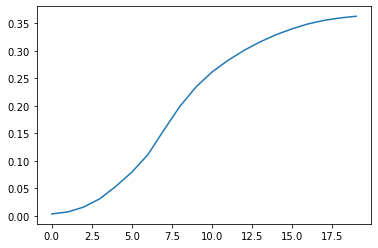

In [41]:
import matplotlib.pyplot as plt
plt.plot(glove_scores)

### Dice coefficient [0.5 points]

Implement the Dice coefficient for real-valued vectors, as

$$
\textbf{dice}(u, v) = 
1 - \frac{
  2 \sum_{i=1}^{n}\min(u_{i}, v_{i})
}{
    \sum_{i=1}^{n} u_{i} + v_{i}
}$$
 
You can use `test_dice_implementation` below to check that your implementation is correct.

In [42]:
def dice(u, v):
    return 1 - 2 * np.sum(np.minimum(u,v)) / np.sum(u + v)

In [43]:
def test_dice_implementation(func):
    """`func` should be an implementation of `dice` as defined above."""
    X = np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]])
    assert func(X[0], X[1]).round(5) == 0.80198
    assert func(X[1], X[2]).round(5) == 0.67568

In [44]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_dice_implementation(dice)

### t-test reweighting [2 points]



The t-test statistic can be thought of as a reweighting scheme. For a count matrix $X$, row index $i$, and column index $j$:

$$\textbf{ttest}(X, i, j) = 
\frac{
    P(X, i, j) - \big(P(X, i, *)P(X, *, j)\big)
}{
\sqrt{(P(X, i, *)P(X, *, j))}
}$$

where $P(X, i, j)$ is $X_{ij}$ divided by the total values in $X$, $P(X, i, *)$ is the sum of the values in row $i$ of $X$ divided by the total values in $X$, and $P(X, *, j)$ is the sum of the values in column $j$ of $X$ divided by the total values in $X$.

For this problem, implement this reweighting scheme. You can use `test_ttest_implementation` below to check that your implementation is correct. You do not need to use this for any evaluations, though we hope you will be curious enough to do so!

In [45]:
 X =  pd.DataFrame(np.array([
        [  4.,   4.,   2.,   100.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]))
X = X.to_numpy()
X_sum = X.sum()
P_j = X.sum(axis=0)/X_sum
P_i = X.sum(axis=1)/X_sum


In [46]:
def ttest(df):
    X = df.to_numpy()
    X_sum = X.sum()
    P_j = X.sum(axis=0) / X_sum
    P_i = X.sum(axis=1) / X_sum
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i,j] = (X[i,j] / X_sum - P_i[i] * P_j[j]) / np.sqrt(P_i[i] * P_j[j])
    return pd.DataFrame(X, index=df.index, columns=df.columns)

In [47]:
def test_ttest_implementation(func):
    """`func` should be `ttest`"""
    X = pd.DataFrame(np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]))
    actual = np.array([
        [ 0.33056, -0.07689,  0.04321, -0.10532],
        [-0.07689,  0.03839, -0.10874,  0.07574],
        [ 0.04321, -0.10874,  0.36111, -0.14894],
        [-0.10532,  0.07574, -0.14894,  0.05767]])
    predicted = func(X)
    #print(predicted)
    assert np.array_equal(predicted.round(5), actual)

In [48]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_ttest_implementation(ttest)

In [49]:
giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
ttest_giga20 = ttest(giga20)
display(full_word_similarity_evaluation(ttest_giga20))

wordsim353         0.543632
mturk771           0.604347
simverb3500dev     0.205704
simverb3500test    0.140476
men                0.725626
Macro-average      0.443957
Name: Spearman r, dtype: float64

Le meilleur résultat pour l'instant!

### Enriching a VSM with subword information [2 points]

It might be useful to combine character-level information with word-level information. To help you begin asssessing this idea, this question asks you to write a function that modifies an existing VSM so that the representation for each word $w$ is the element-wise sum of $w$'s original word-level representation with all the representations for the n-grams $w$ contains. 

The following starter code should help you structure this and clarify the requirements, and a simple test is included below as well.

You don't need to write a lot of code; the motivation for this question is that the function you write could have practical value.

In [50]:
vsm.get_character_ngrams('mot', n=2)

['<w>m', 'mo', 'ot', 't</w>']

In [51]:
words = ['bon', 'bel']
df = pd.DataFrame([[1, 2], [3, 4]], index=words, columns=words)
df

,bon,bel
bon,1,2
bel,3,4


In [52]:
cf = vsm.ngram_vsm(df, n=2) # Character level VSM
cf

,bon,bel
<w>b,4,6
bo,1,2
on,1,2
n</w>,1,2
be,3,4
el,3,4
l</w>,3,4


In [53]:
vsm.character_level_rep('bon', cf, n=2)

array([ 7, 12])

Pour chaque mot on somme tous les bi-grammes au niveau des caractères  
Dans notre exemple cette somme est "associée" 10 fois avec `bon` et 16 fois avec `bel`  
Les bi-grammes très réccurents dans la matrice vont augmenter le poids du vecteur (ici `<w>b`)

In [54]:
def subword_enrichment(df, n=4):
    # 1. Use `vsm.ngram_vsm` to create a character-level
    # VSM from `df`, using the above parameter `n` to
    # set the size of the ngrams.

    cf = vsm.ngram_vsm(df, n) # Character level VSM


    # 2. Use `vsm.character_level_rep` to get the representation
    # for every word in `df` according to the character-level
    # VSM you created above.
    
    clr = [] # character level representation
    for w, _ in df.iterrows():
        clr.append(vsm.character_level_rep(w, cf, n))
    clr = np.array(clr)

    # 3. For each representation created at step 2, add in its
    # original representation from `df`. (This should use
    # element-wise addition; the dimensionality of the vectors
    # will be unchanged.)

    # subword enrichment :swe
    swe = df.to_numpy() + clr


    # 4. Return a `pd.DataFrame` with the same index and column
    # values as `df`, but filled with the new representations
    # created at step 3.

    return pd.DataFrame(swe, index=df.index, columns=df.columns)

In [55]:
def test_subword_enrichment(func):
    """`func` should be an implementation of subword_enrichment as
    defined above.
    """
    vocab = ["ABCD", "BCDA", "CDAB", "DABC"]
    df = pd.DataFrame([
        [1, 1, 2, 1],
        [3, 4, 2, 4],
        [0, 0, 1, 0],
        [1, 0, 0, 0]], index=vocab)
    expected = pd.DataFrame([
        [14, 14, 18, 14],
        [22, 26, 18, 26],
        [10, 10, 14, 10],
        [14, 10, 10, 10]], index=vocab)
    new_df = func(df, n=2)
    assert np.array_equal(expected.columns, new_df.columns), \
        "Columns are not the same"
    assert np.array_equal(expected.index, new_df.index), \
        "Indices are not the same"
    assert np.array_equal(expected.values, new_df.values), \
        "Co-occurrence values aren't the same"

In [56]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_subword_enrichment(subword_enrichment)

In [57]:
giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
swe_giga20 = subword_enrichment(giga20)
display(full_word_similarity_evaluation(swe_giga20))

wordsim353        -0.102895
mturk771          -0.006531
simverb3500dev     0.012539
simverb3500test    0.006986
men                0.064051
Macro-average     -0.005170
Name: Spearman r, dtype: float64

### Your original system [3 points]

This question asks you to design your own model. You can of course include steps made above (ideally, the above questions informed your system design!), but your model should not be literally identical to any of the above models. Other ideas: retrofitting, autoencoders, GloVe, subword modeling, ... 

Requirements:

1. Your code must operate on one or more of the count matrices in `data/vsmdata`. You can choose which subset of them; this is an important design feature of your system. __Other pretrained vectors cannot be introduced__.

1. Retrofitting is permitted.

1. Your code must be self-contained, so that we can work with your model directly in your homework submission notebook. If your model depends on external data or other resources, please submit a ZIP archive containing these resources along with your submission.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best score your system got during development, just to help us understand how systems performed overall.

In [58]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
x = subword_enrichment(giga20)
x = vsm.pmi(x)
#x = vsm.lsa(x, k=10)
#x = ttest(x) 0.18
#display(full_word_similarity_evaluation(x))

n_runs = 10
from torch_glove import TorchGloVe
#X = pd.read_csv(os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)
mod = TorchGloVe(warm_start=True, max_iter=50)
results = []
for run in range(n_runs):
    G = mod.fit(x)
    G_lsa = vsm.lsa(G, k=10)
    series = full_word_similarity_evaluation(G_lsa)
    print(series['Macro-average'])


# STOP COMMENT: Please do not remove this comment.

Finished epoch 50 of 50; error is 43528.75439453125

0.10821805996116596


Finished epoch 50 of 50; error is 30335.89013671875

0.14847192304761944


Finished epoch 50 of 50; error is 21547.450683593755

0.16082345985385121


Finished epoch 50 of 50; error is 18068.280761718755

0.16584782210013793


Finished epoch 50 of 50; error is 16539.783447265625

0.17275752490216237


Finished epoch 50 of 50; error is 15738.956298828125

0.18012496625847577


Finished epoch 50 of 50; error is 15258.352539062525

0.18592604498960866


Finished epoch 50 of 50; error is 14940.821777343755

0.19189856469920447


Finished epoch 50 of 50; error is 14717.021728515625

0.19564005223363895


Finished epoch 50 of 50; error is 14551.838867187555

0.1985481278953166


In [59]:
series = full_word_similarity_evaluation(G)
print(series['Macro-average'])

0.35093707235233207


VSM: retrofitting

In [60]:
#G_retrofitted = os.path.join(PATH_TO_DATA, 'glove6B300d-retrofit-wn.csv.gz')
#import utils
G_retrofitted = pd.read_csv(os.path.join(PATH_TO_DATA, "glove6B300d-retrofit-wn.csv.gz"),
                           index_col=0)
#glove_dict = utils.glove2dict(os.path.join(PATH_TO_DATA, "glove6B300d-retrofit-wn.csv.gz"))

In [61]:
G_retrofitted.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [62]:
full_word_similarity_evaluation(G_retrofitted)

ValueError: Word 'misspend' is in the similarity dataset simverb3500dev but not in the DataFrame, making this evaluation ill-defined. Please switch to a DataFrame with an appropriate vocabulary.

## Bake-off [1 point]

For the bake-off, we will release two additional datasets. The announcement will go out on the discussion forum. We will also release reader code for these datasets that you can paste into this notebook. You will evaluate your custom model $M$ (from the previous question) on these new datasets using `full_word_similarity_evaluation`. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

The cells below this one constitute your bake-off entry.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
# Enter your bake-off assessment code into this cell.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your code in the scope of the above conditional.
    ##### YOUR CODE HERE


In [ ]:
# On an otherwise blank line in this cell, please enter
# your "Macro-average" value as reported by the code above.
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your score in the scope of the above conditional.
    ##### YOUR CODE HERE
